In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
from rich.console import Console
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error

ROOT_DIR = os.path.dirname(
os.path.dirname(os.path.abspath('')))


sys.path.append(os.path.join(ROOT_DIR, "code"))
from tools.data_loader import TestSet, TestSplit, data_loader
from tools.save import save_as_baseline, save_datasets, save_models
from tools.train import evaluate_models, print_test_samples, train_models, print_problematic_samples
from tools.utils import StructureEncoding, Target, check_xgboost_gpu

# Define global variables
DATA_DIR = os.path.join(ROOT_DIR, "data/")

DATA_PATH = os.path.join(DATA_DIR, "data.csv")


In [2]:
console = Console(record=True)
prompt_user = False

encoding = StructureEncoding.ATOMIC

console.log(f"[bold green]Started pipeline for {encoding}")
target = Target.DELTA_E
test_sets_cfg = [
    TestSet("Parameter gen.", size=0.1, split=TestSplit.ROW),
    TestSet("Structure gen.", size=0.1, split=TestSplit.STRUCTURE),
]

# Data Loading
X_train, y_train, test_sets = data_loader(
    target=target,
    encoding=encoding,
    data_path=DATA_PATH,
    test_sets_cfg=test_sets_cfg,
    console=console,
    remove_ref_rows=True,
)

[10:14:58] Started pipeline for StructureEncoding.ATOMIC                      ]8;id=566903;file:///var/folders/zv/j2vc13hx0x72z8g7wvs60p3w0000gn/T/ipykernel_20871/2179649547.py\2179649547.py]8;;\:]8;id=437933;file:///var/folders/zv/j2vc13hx0x72z8g7wvs60p3w0000gn/T/ipykernel_20871/2179649547.py#6\6]8;;\

Output()

╭───────── Loaded Dataset ─────────╮
│ Train set: 80%                   │
│ Test set 0 (Parameter gen.): 10% │
│ Test set 1 (Structure gen.): 10% │
│ Total datapoints: 539583         │
│ Size: ~388.5MB                   │
╰──────────────────────────────────╯

In [3]:
base = 10
def magnitude(x):
    return int(np.ceil(np.log(x) / np.log(base)))

def magnitude_inv(x):
    return base**float(x-1)
    # for the regression transformation, taking the prediction minus 1 yields way better MAPE scores
    # I think that's because predicting a result with an order of magnitude superior to the actual value
    # yields an APE error of 10 (1000%) while predicting a result with an order of magnitude inferior to the actual value
    # yields an APE error of at most 1 (100%)

def magnitude_transform(a):
    return np.vectorize(magnitude)(a)

def magnitude_inv_transform(a):
    return np.vectorize(magnitude_inv)(a)

In [5]:
param_gen_test = test_sets[0]
_, X_test_param, y_test_param = param_gen_test

struct_gen_test = test_sets[1]
_, X_test_struct, y_test_struct = struct_gen_test

In [6]:
magnitude_y_train = magnitude_transform(y_train)
magnitude_y_test_param = magnitude_transform(y_test_param)
magnitude_y_test_struct = magnitude_transform(y_test_struct)

In [7]:
#model = RandomForestClassifier(random_state=0) 
#model.fit(X_train, magnitude_y_train)

In [8]:
#for test_name, X_test, y_test in test_sets:
    #magnitude_y_pred = model.predict(X_test)
    #magnitude_y_test = magnitude_transform(y_test)
    #score = accuracy_score(magnitude_y_test, magnitude_y_pred)
    #mape = mean_absolute_percentage_error(y_test, magnitude_inv_transform(magnitude_y_pred))
    #console.print(f"Accuracy {test_name}: {score*100}%")
    #console.print(f"MAPE {test_name}: {mape}")

# Hyperparameter tuning

In [25]:
rf_model = RandomForestClassifier(random_state=0) 

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 250, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator = rf_model,
    param_distributions = random_grid,
    n_iter = 10,
    cv = 2,
    verbose=1)

In [28]:
rf_random.fit(X_test_param, magnitude_y_test_param)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'max_depth': [50, 72, 94, 116, 138, 161,
                                                      183, 205, 227, 250,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 62, 114, 166, 218,
                                                         270, 322, 374, 426,
                                                         478, 531, 583, 635,
                                                         687, 739, 791, 843,
                                                         895, 947, 1000]},
                   verbose=1)

In [29]:
rf_random.best_params_

{'n_estimators': 426, 'max_features': 'auto', 'max_depth': 161}

params = {'n_estimators': 878, 'max_features': 'auto', 'max_depth': 100}

In [30]:
rf_best = RandomForestClassifier(random_state=0)
rf_best.set_params(**rf_random.best_params_)
#rf_best.set_params(**params)

RandomForestClassifier(max_depth=161, n_estimators=426, random_state=0)

In [31]:
rf_best.fit(X_train, magnitude_y_train)

RandomForestClassifier(max_depth=161, n_estimators=426, random_state=0)

RandomForestClassifier(max_depth=161, n_estimators=426, random_state=0)

for test_name, X_test, y_test in test_sets:
    magnitude_y_pred = rf_best.predict(X_test)
    magnitude_y_test = magnitude_transform(y_test)
    score = accuracy_score(magnitude_y_test, magnitude_y_pred)
    mape = mean_absolute_percentage_error(y_test, magnitude_inv_transform(magnitude_y_pred))
    console.print(f"Accuracy {test_name}: {score*100}%")
    #console.print(f"MAPE {test_name}: {mape}")

In [33]:
rf_random.fit(X_test_struct, magnitude_y_test_struct)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'max_depth': [50, 72, 94, 116, 138, 161,
                                                      183, 205, 227, 250,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 62, 114, 166, 218,
                                                         270, 322, 374, 426,
                                                         478, 531, 583, 635,
                                                         687, 739, 791, 843,
                                                         895, 947, 1000]},
                   verbose=1)

In [34]:
rf_random.best_params_

{'n_estimators': 218, 'max_features': 'sqrt', 'max_depth': 205}

In [35]:
rf_best = RandomForestClassifier(random_state=0)
rf_best.set_params(**rf_random.best_params_)
#rf_best.set_params(**params)

RandomForestClassifier(max_depth=205, max_features='sqrt', n_estimators=218,
                       random_state=0)

In [36]:
rf_best.fit(X_train, magnitude_y_train)

RandomForestClassifier(max_depth=205, max_features='sqrt', n_estimators=218,
                       random_state=0)

In [37]:
for test_name, X_test, y_test in test_sets:
    magnitude_y_pred = rf_best.predict(X_test)
    magnitude_y_test = magnitude_transform(y_test)
    score = accuracy_score(magnitude_y_test, magnitude_y_pred)
    mape = mean_absolute_percentage_error(y_test, magnitude_inv_transform(magnitude_y_pred))
    console.print(f"Accuracy {test_name}: {score*100}%")
    console.print(f"MAPE {test_name}: {mape}")

Accuracy Parameter gen.: 97.41094925682938%

MAPE Parameter gen.: 0.8715415691412579

Accuracy Structure gen.: 69.84229738720757%

MAPE Structure gen.: 10.621532891261362

In [62]:
custom_params = {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 200}
rf_custom = RandomForestClassifier(random_state=0)
rf_custom.set_params(**custom_params)
rf_custom.fit(X_train, magnitude_y_train)

RandomForestClassifier(max_depth=200, max_features='sqrt', n_estimators=1000,
                       random_state=0)

In [63]:
for test_name, X_test, y_test in test_sets:
    magnitude_y_pred = rf_custom.predict(X_test)
    magnitude_y_test = magnitude_transform(y_test)
    score = accuracy_score(magnitude_y_test, magnitude_y_pred)
    #mape = mean_absolute_percentage_error(y_test, magnitude_inv_transform(magnitude_y_pred))
    console.print(f"Accuracy {test_name}: {score*100}%")
    console.print(f"MAPE {test_name}: {mape}")

Accuracy Parameter gen.: 97.41650913673598%

MAPE Parameter gen.: 10.621532891261362

Accuracy Structure gen.: 70.31342719965474%

MAPE Structure gen.: 10.621532891261362

In [64]:
rf_custom

RandomForestClassifier(max_depth=200, max_features='sqrt', n_estimators=1000,
                       random_state=0)

In [65]:
importances = rf_custom.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_custom.estimators_], axis=0)

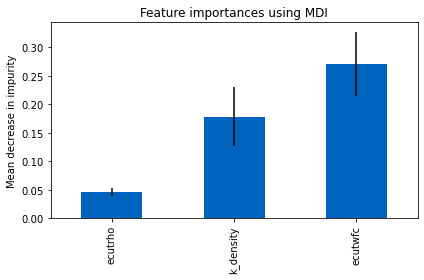

In [72]:
blue = "#0063be"
yellow = "#fed900"
green = "#007836"
orange = "#ff6f20"
purple = "#580f8b"

import matplotlib.pyplot as plt
rf_importances = pd.Series(importances[:3], index=X_train.columns[:3])

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std[:3], ax=ax, color=blue)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()